# Using **dask**

[dask](https://dask.org/) is a Python package built upon the scientific stack to enable scalling of Python through interactive sessions to multi-core and multi-node.

Of particular relevance to **SEGY-SAK** is that `xrray.Dataset` loads naturally into `dask`.

## Imports and Setup

Here we import the plotting tools, `numpy` and setup the `dask.Client` which will auto start a `localcluster`. Printing the client returns details about the dashboard link and resources.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from segysak import open_seisnc, segy

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41753,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:45419,Total threads: 1
Dashboard: http://127.0.0.1:40943/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:35265,


We can also scale the cluster to be a bit smaller.

In [4]:
client.cluster.scale(2, memory="0.5gb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 7.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41753,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 3
Started: Just now,Total memory: 11.70 GiB
Comm: tcp://127.0.0.1:45419,Total threads: 1
Dashboard: http://127.0.0.1:40943/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:35265,


## Lazy loading from SEISNC using chunking

If your data is in SEG-Y to use dask it must be converted to SEISNC. If you do this with the CLI it only need happen once.

In [5]:
segy_file = "data/volve10r12-full-twt-sub3d.sgy"
seisnc_file = "data/volve10r12-full-twt-sub3d.seisnc"
segy.segy_converter(
    segy_file, seisnc_file, iline=189, xline=193, cdp_x=181, cdp_y=185, silent=True
)

header_loaded
is_3d
Fast direction is INLINE_3D


By specifying the chunks argument to the `open_seisnc` command we can ask dask to fetch the data in chunks of size *n*. In this example the `iline` dimension will be chunked in groups of 100. The valid arguments to chunks depends on the dataset but any dimension can be used.

Even though the seis of the dataset is `2.14GB` it hasn't yet been loaded into memory, not will `dask` load it entirely unless the operation demands it.

In [6]:
seisnc = open_seisnc("data/volve10r12-full-twt-sub3d.seisnc", chunks={"iline": 100})
seisnc.seis.humanbytes

'40.05 MB'

Lets see what our dataset looks like. See that the variables are `dask.array`. This means they are references to the on disk data. The dimensions must be loaded so `dask` knows how to manage your dataset.

In [7]:
seisnc

<xarray.Dataset> Size: 42MB
Dimensions:  (iline: 61, xline: 202, twt: 850)
Coordinates:
  * iline    (iline) uint16 122B 10090 10091 10092 10093 ... 10148 10149 10150
  * xline    (xline) uint16 404B 2150 2151 2152 2153 ... 2348 2349 2350 2351
  * twt      (twt) float64 7kB 4.0 8.0 12.0 16.0 ... 3.392e+03 3.396e+03 3.4e+03
    cdp_x    (iline, xline) float32 49kB dask.array<chunksize=(61, 202), meta=np.ndarray>
    cdp_y    (iline, xline) float32 49kB dask.array<chunksize=(61, 202), meta=np.ndarray>
Data variables:
    data     (iline, xline, twt) float32 42MB dask.array<chunksize=(61, 202, 850), meta=np.ndarray>
Attributes: (12/13)
    sample_rate:         4.0
    text:                C 1 SEGY OUTPUT FROM Petrel 2017.2 Saturday, June 06...
    measurement_system:  m
    source_file:         volve10r12-full-twt-sub3d.sgy
    percentiles:         [-6.59506019e+00 -6.11493624e+00 -1.50399996e+00 -3....
    coord_scalar:        -100.0
    ...                  ...
    d3_domain:           None
    epsg:                None
    corner_points:       None
    corner_points_xy:    None
    srd:                 None
    datatype:            None

## Operations on SEISNC using `dask`

In this simple example we calculate the mean, of the entire cube. If you check the dashboard (when running this example yourself). You can see the task graph and task stream execution.

In [8]:
mean = seisnc.data.mean()
mean

<xarray.DataArray 'data' ()> Size: 4B
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

Whoa-oh, the mean is what? Yeah, `dask` won't calculate anything until you ask it to. This means you can string computations together into a task graph for lazy evaluation. To get the mean try this

In [9]:
mean.compute().values

array(-7.317369e-05, dtype=float32)

## Plotting with `dask`

The lazy loading of data means we can plot what we want using `xarray` style slicing and `dask` will fetch only the data we need.

Text(0.5, 1.0, 'twt')

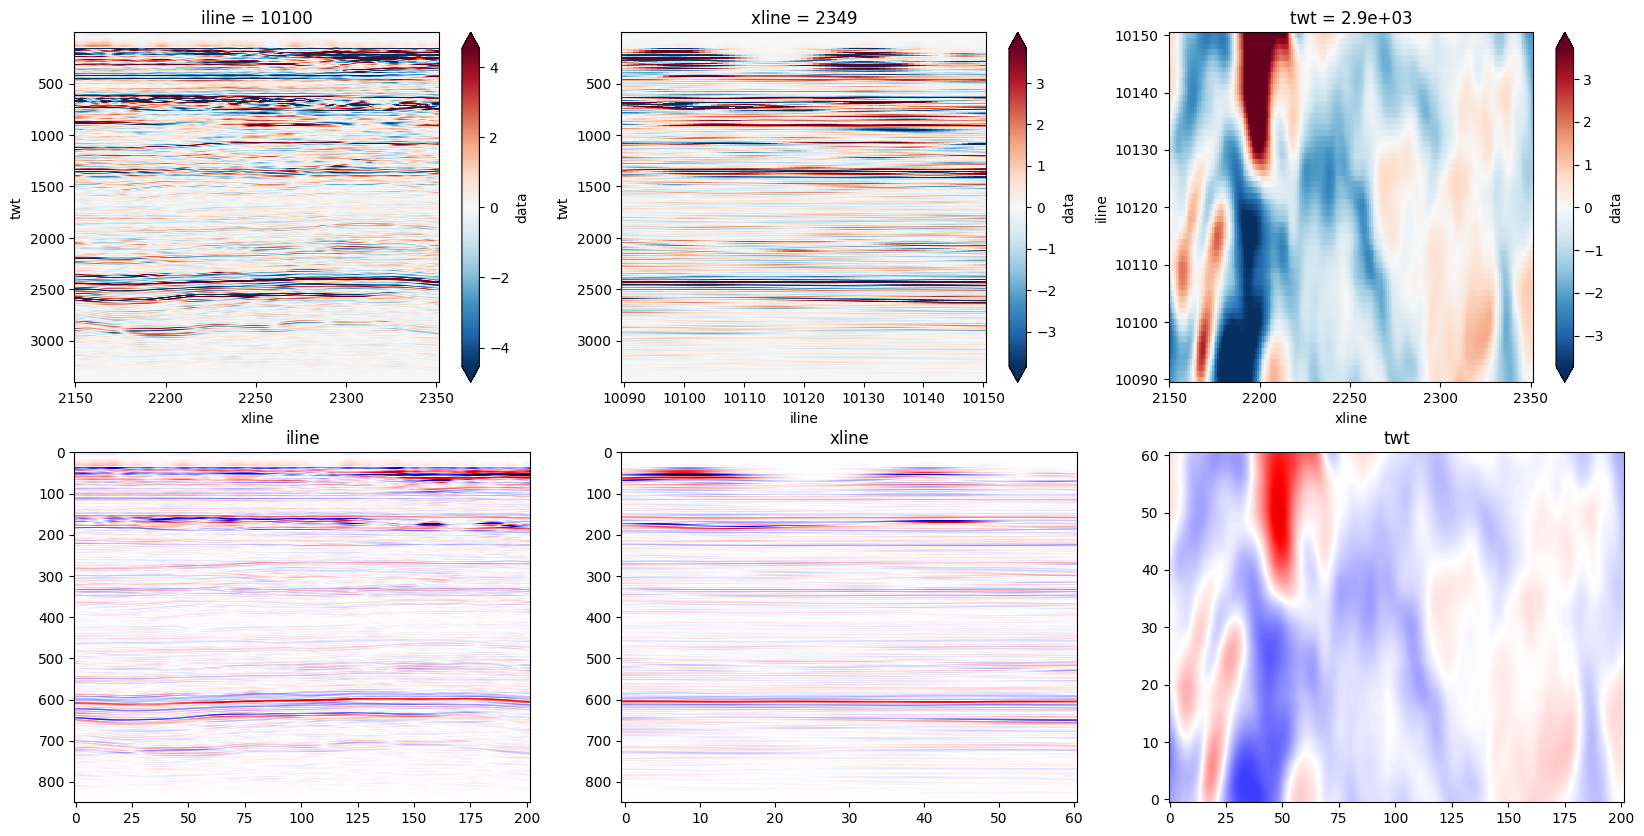

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

iline = seisnc.sel(iline=10100).transpose("twt", "xline").data
xline = seisnc.sel(xline=2349).transpose("twt", "iline").data
zslice = seisnc.sel(twt=2900, method="nearest").transpose("iline", "xline").data

q = iline.quantile([0, 0.001, 0.5, 0.999, 1]).values
rq = np.max(np.abs([q[1], q[-2]]))

iline.plot(robust=True, ax=axs[0, 0], yincrease=False)
xline.plot(robust=True, ax=axs[0, 1], yincrease=False)
zslice.plot(robust=True, ax=axs[0, 2])

imshow_kwargs = dict(
    cmap="seismic", aspect="auto", vmin=-rq, vmax=rq, interpolation="bicubic"
)

axs[1, 0].imshow(iline.values, **imshow_kwargs)
axs[1, 0].set_title("iline")
axs[1, 1].imshow(xline.values, **imshow_kwargs)
axs[1, 1].set_title("xline")
axs[1, 2].imshow(zslice.values, origin="lower", **imshow_kwargs)
axs[1, 2].set_title("twt")